# Modelling & Simulation Coursework
## Mathematical Modelling of Zombie Outbreak with Cure Introduction

This is a Jupyter Notebook accompanying the report. In this notebook, we will go through the numerical calculations discussed in the report and its basic analysis of the results. This notebook will omit the calculations for the Base Model, refer to the Wolfram Mathematica for it. There is also an additional Wolfram Mathematica Notebook on the same implementation of the cure, however the analysis done there is not as extensive as the ones shown here. For more information, refer to the main report PDF.

In [103]:
import numpy as np
import sympy as sp
from sympy import symbols, solve
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.linalg import eigvals
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import uniform_filter1d
from copy import deepcopy
import ipywidgets
from ipywidgets import interact, FloatSlider
from matplotlib.animation import FuncAnimation

## Cure Model with Heaviside Function
Let us start with defining the default parameters of the system. Here we will assume that the model plays over a short period of time, meaning there is no effects of natural birth and death in play.

In [15]:
default_parameters = {
    "alpha": 0.05,  # Zombie killing rate
    "beta": 0.053,  # Infection rate
    "gamma": 0.3,   # Cure effectiveness
    "zeta": 0.005,  # Resurrection rate
    "tau": 5,      # Cure delay
    
    #We will assume delta and Pi to be 0 to simplify the system
    "delta": 0.0,   # Susceptible death rate
    "Pi": 0.0      # Susceptible birthrate
}

# Initial conditions
S0 = 500  # Initial susceptible population
Z0 = 1    # Initial zombie population
R0 = 0    # Initial removed population
initial_conditions = [S0, Z0, R0]  # Combine into an initial state vector

Now we can define the system.

In [16]:
# Define Heaviside function
def heaviside(t, tau):
    """Heaviside step function."""
    return 1 if t >= tau else 0

In [17]:
# Cure Model with heaviside function
def cure_model_heaviside(t, y, params):
    """ODE system incorporating Heaviside function."""
    S, Z, R = y
    H_t_tau = heaviside(t, params["tau"])  # Use Heaviside function
    dS_dt = params["Pi"] + params["gamma"] * S * H_t_tau * Z - params["beta"] * S * Z - params["delta"]
    dZ_dt = params["beta"] * S * Z + params["zeta"] * R - params["alpha"] * S * Z - params["gamma"] * S * Z * H_t_tau
    dR_dt = params["delta"] + params["alpha"] * S * Z - params["zeta"] * R
    return [dS_dt, dZ_dt, dR_dt]

### Initial Phase Diagram & Time-Series Plot
Now we want to find the basic characteristic of this model. The quickest way is to just plot the phase diagram with the time-series plot.

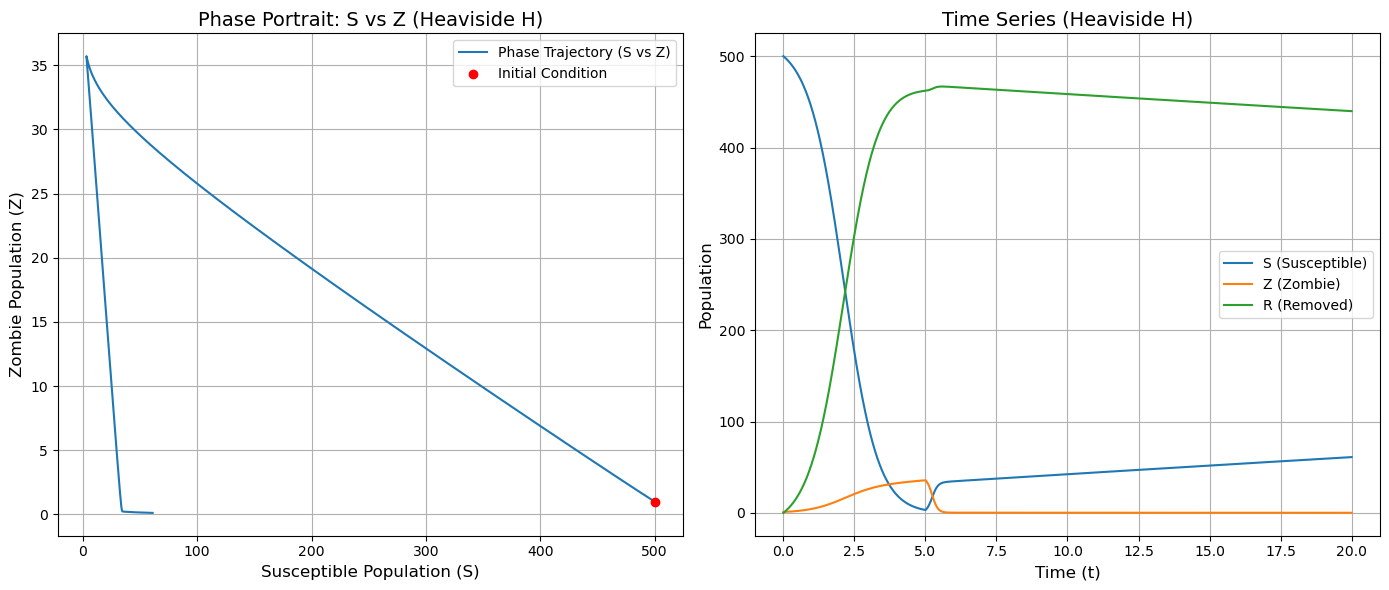

In [18]:
# Time span for simulation
t_span = (0, 20)  # Start and end time
t_eval = np.linspace(*t_span, 1000)  # Evaluation points

# Solve the system of ODEs
solution_heaviside = solve_ivp(
    cure_model_heaviside, 
    t_span, 
    initial_conditions, 
    t_eval=t_eval, 
    method='RK45', 
    args=(default_parameters,)
)

# Extract results
S_heaviside, Z_heaviside, R_heaviside = solution_heaviside.y

# Plot the phase portrait and time series side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Phase Portrait: S vs Z
axes[0].plot(S_heaviside, Z_heaviside, label='Phase Trajectory (S vs Z)')
axes[0].scatter(S0, Z0, color='red', label='Initial Condition', zorder=5)
axes[0].set_xlabel('Susceptible Population (S)', fontsize=12)
axes[0].set_ylabel('Zombie Population (Z)', fontsize=12)
axes[0].set_title('Phase Portrait: S vs Z (Heaviside H)', fontsize=14)
axes[0].legend()
axes[0].grid(True)

# Time Series Plot
axes[1].plot(solution_heaviside.t, S_heaviside, label='S (Susceptible)')
axes[1].plot(solution_heaviside.t, Z_heaviside, label='Z (Zombie)')
axes[1].plot(solution_heaviside.t, R_heaviside, label='R (Removed)')
axes[1].set_xlabel('Time (t)', fontsize=12)
axes[1].set_ylabel('Population', fontsize=12)
axes[1].set_title('Time Series (Heaviside H)', fontsize=14)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

From this system, we can see that there is an eradication of human. Let the cure effective rate be the main parameter here. Now we know that when the other variables are constant, when gamma = 0.3, human barely got out alive.

Knowing that the system is extremely sensitive to starting conditions, let us find the Lyapunov Exponent. In this case, we are going to slightly increase beta to make it more interesting.

### Lyapunov Exponent

In [6]:
# Update Parameters
lyapunov_parameters = {
    "alpha": 0.05,  # Zombie killing rate
    "beta": 0.059,  # Infection rate (We increase it to increase 'spiciness' to the system)
    "gamma": 0.3,   # Cure effectiveness
    "zeta": 0.005,  # Resurrection rate
    "tau": 3,      # Cure delay
    
    #We will assume delta and Pi to be 0 to simplify the system
    "delta": 0.0,   # Susceptible death rate
    "Pi": 0.0      # Susceptible birthrate
}

t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 1000)
epsilon = np.finfo(np.float32).eps
# Correct initial conditions and parameters
initial_conditions = [S0, Z0, R0]
perturbed_conditions = [S0 + epsilon, Z0, R0]  # Slightly perturbed initial conditions

In [7]:
def compute_separation(tau, initial_conditions, perturbed_conditions, t_span, t_eval, epsilon, params):
    """Compute the separation between original and perturbed trajectories for a given tau."""
    params["tau"] = tau  # Update tau in parameters

    # Solve ODEs
    sol_original = solve_ivp(
        cure_model_heaviside,
        t_span=t_span,
        y0=initial_conditions,
        t_eval=t_eval,
        method='RK45',
        args=(params,)
    )
    sol_perturbed = solve_ivp(
        cure_model_heaviside,
        t_span=t_span,
        y0=perturbed_conditions,
        t_eval=t_eval,
        method='RK45',
        args=(params,)
    )

    # Interpolate solutions
    interp_original = interp1d(sol_original.t, sol_original.y, kind='linear', fill_value="extrapolate")
    interp_perturbed = interp1d(sol_perturbed.t, sol_perturbed.y, kind='linear', fill_value="extrapolate")

    # Evaluate interpolations
    y_orig = interp_original(t_eval)
    y_pert = interp_perturbed(t_eval)

    # Compute separation
    separation = np.sqrt(np.sum((y_orig - y_pert)**2, axis=0))
    return separation

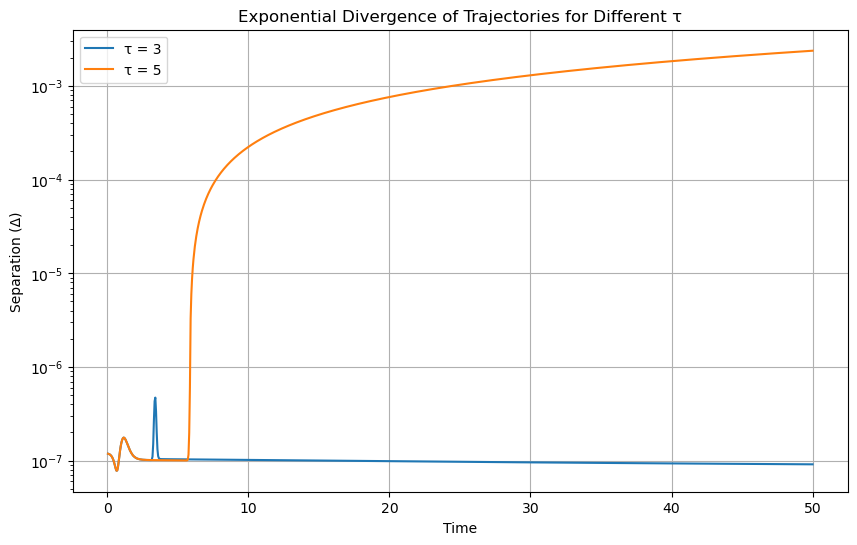

Largest Lyapunov Exponent for τ = 3: -0.0117
Largest Lyapunov Exponent for τ = 5: 0.3481


In [8]:
# Compute separations for different tau values
separation_tau_3 = compute_separation(3, initial_conditions, perturbed_conditions, t_span, t_eval, epsilon, lyapunov_parameters)
separation_tau_5 = compute_separation(5, initial_conditions, perturbed_conditions, t_span, t_eval, epsilon, lyapunov_parameters)

# Plot separations for both tau values
plt.figure(figsize=(10, 6))
plt.plot(t_eval[1:], separation_tau_3[1:], label="τ = 3")
plt.plot(t_eval[1:], separation_tau_5[1:], label="τ = 5")
plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("Separation (Δ)")
plt.title("Exponential Divergence of Trajectories for Different τ")
plt.legend()
plt.grid(True)
plt.show()

# Compute and print Lyapunov exponents for both tau values
log_sep_tau_3 = np.log(separation_tau_3[1:] / epsilon)
lyapunov_tau_3 = np.mean(log_sep_tau_3 / t_eval[1:])
print(f"Largest Lyapunov Exponent for τ = 3: {lyapunov_tau_3:.4f}")

log_sep_tau_5 = np.log(separation_tau_5[1:] / epsilon)
lyapunov_tau_5 = np.mean(log_sep_tau_5 / t_eval[1:])
print(f"Largest Lyapunov Exponent for τ = 5: {lyapunov_tau_5:.4f}")

## Interactive Lyapunov Plot
Try for yourself! See how the system would change with different tau!

In [62]:
# Define the function to compute separation
def compute_separation(tau, initial_conditions, perturbed_conditions, t_span, t_eval, epsilon, params):
    params["tau"] = tau  # Update tau in parameters

    # Solve ODEs
    sol_original = solve_ivp(
        cure_model_heaviside,
        t_span=t_span,
        y0=initial_conditions,
        t_eval=t_eval,
        method='RK45',
        args=(params,)
    )
    sol_perturbed = solve_ivp(
        cure_model_heaviside,
        t_span=t_span,
        y0=perturbed_conditions,
        t_eval=t_eval,
        method='RK45',
        args=(params,)
    )

    # Interpolate solutions
    interp_original = interp1d(sol_original.t, sol_original.y, kind='linear', fill_value="extrapolate")
    interp_perturbed = interp1d(sol_perturbed.t, sol_perturbed.y, kind='linear', fill_value="extrapolate")

    # Evaluate interpolations
    y_orig = interp_original(t_eval)
    y_pert = interp_perturbed(t_eval)

    # Compute separation
    separation = np.sqrt(np.sum((y_orig - y_pert)**2, axis=0))
    return separation

# Define plotting function
def plot_separation(tau):
    separation = compute_separation(
        tau, 
        initial_conditions, 
        perturbed_conditions, 
        t_span, 
        t_eval, 
        epsilon, 
        lyapunov_parameters
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(t_eval[1:], separation[1:], label=f"τ = {tau:.2f}")
    plt.yscale('log')
    plt.xlabel("Time")
    plt.ylabel("Separation (Δ)")
    plt.title(f"Exponential Divergence of Trajectories for τ = {tau:.2f}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive slider for tau
interact(
    plot_separation, 
    tau=FloatSlider(value=3, min=1, max=10, step=0.1, description="τ")
)

interactive(children=(FloatSlider(value=3.0, description='τ', max=10.0, min=1.0), Output()), _dom_classes=('wi…

<function __main__.plot_separation(tau)>

So, from this we know that the system is chaotic for tau because one of the exponent is negative and another is positive. The next step is to plot the Fractal Basin Boundary Colour map to see its charactersitics.

## Fractal Basin Boundary Colour Map

In [19]:
#Declare the simulation time span
t_span = (0, 50)

In [20]:
# Create a grid of initial conditions
n_points = 200
S_range = np.linspace(0, 500, n_points)  # Susceptibles
Z_range = np.linspace(0, 100, n_points)  # Zombies
R_initial = 0  # Removed population is fixed at 0

# Initialize a matrix to store results
basin_matrix = np.zeros((n_points, n_points))

# Define thresholds for the final state classification
zombie_threshold = 1.0  # If Z < 1, the zombie population is eradicated
susceptible_threshold = 1.0  # If S < 1, the susceptible population collapses

In [21]:
# Simulate the system for each initial condition
for i, S0 in enumerate(S_range):
    for j, Z0 in enumerate(Z_range):
        initial_conditions = [S0, Z0, R_initial]
        
        # Solve the system using solve_ivp
        solution = solve_ivp(
            cure_model_heaviside,
            t_span,
            y0=initial_conditions,
            method='RK45',
            t_eval=np.linspace(*t_span, 100),
            args=(default_parameters,)
        )
        
        # Extract final values
        S_final = solution.y[0, -1]  # Susceptible population
        Z_final = solution.y[1, -1]  # Zombie population
        R_final = solution.y[2, -1]  # Removed population

        # Classify the final state
        if Z_final < zombie_threshold and S_final > susceptible_threshold:
            basin_matrix[j, i] = 1  # Healthy population
        elif Z_final >= zombie_threshold:
            basin_matrix[j, i] = 2  # Zombies dominate
        else:
            basin_matrix[j, i] = 3  # Population collapse

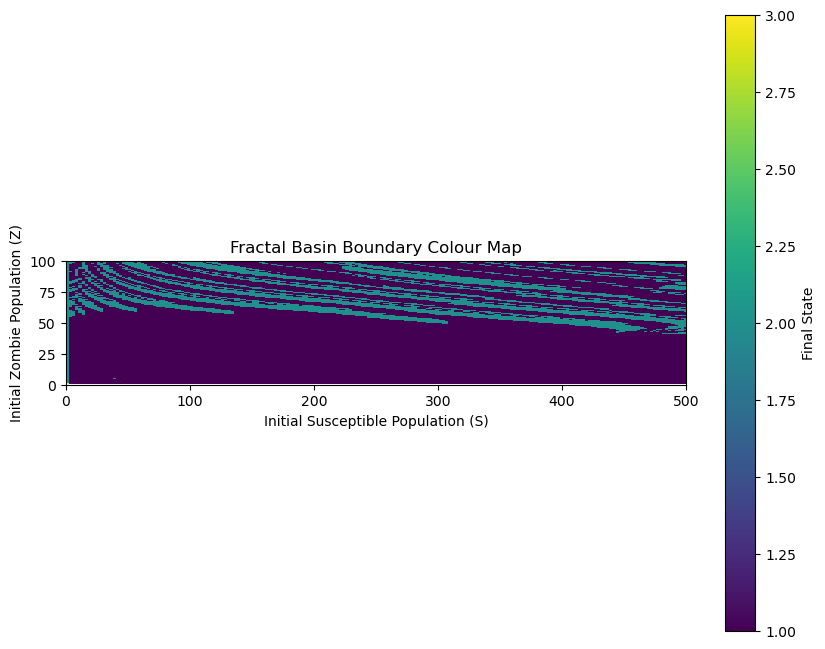

In [22]:
# Plot the fractal basin boundary
plt.figure(figsize=(10, 8))
plt.imshow(
    basin_matrix,
    extent=[S_range.min(), S_range.max(), Z_range.min(), Z_range.max()],
    origin='lower',
    cmap='viridis',
    interpolation='nearest'
)
plt.colorbar(label='Final State')
plt.title('Fractal Basin Boundary Colour Map')
plt.xlabel('Initial Susceptible Population (S)')
plt.ylabel('Initial Zombie Population (Z)')
plt.show()

## 3D Fractal Basin Boundary Colour Map
Now lets see how its going to affect the removed population:

In [23]:
# Create a grid of initial conditions
n_points = 20  # Reduced for computational feasibility
S_range = np.linspace(0, 500, n_points)  # Susceptibles
Z_range = np.linspace(0, 100, n_points)  # Zombies
R_range = np.linspace(0, 50, n_points)  # Removed

# Store results for final classification
final_states = []

In [24]:
# Simulate the system for each combination of S, Z, R
for S0 in S_range:
    for Z0 in Z_range:
        for R0 in R_range:
            initial_conditions = [S0, Z0, R0]
            
            # Solve the system using solve_ivp
            solution = solve_ivp(
                cure_model_heaviside,
                t_span,
                y0=initial_conditions,
                method='RK45',
                t_eval=np.linspace(*t_span, 100),
                args=(default_parameters,)
            )
            
            # Extract final values
            S_final, Z_final, R_final = solution.y[:, -1]

            # Classify the final state
            if Z_final < 1.0 and S_final > 1.0:
                state = 1  # Healthy population
            elif Z_final >= 1.0:
                state = 2  # Zombies dominate
            else:
                state = 3  # Population collapse

            final_states.append((S0, Z0, R0, state))

# Convert results to arrays for plotting
final_states = np.array(final_states)
S_vals = final_states[:, 0]
Z_vals = final_states[:, 1]
R_vals = final_states[:, 2]
states = final_states[:, 3]

<IPython.core.display.Javascript object>


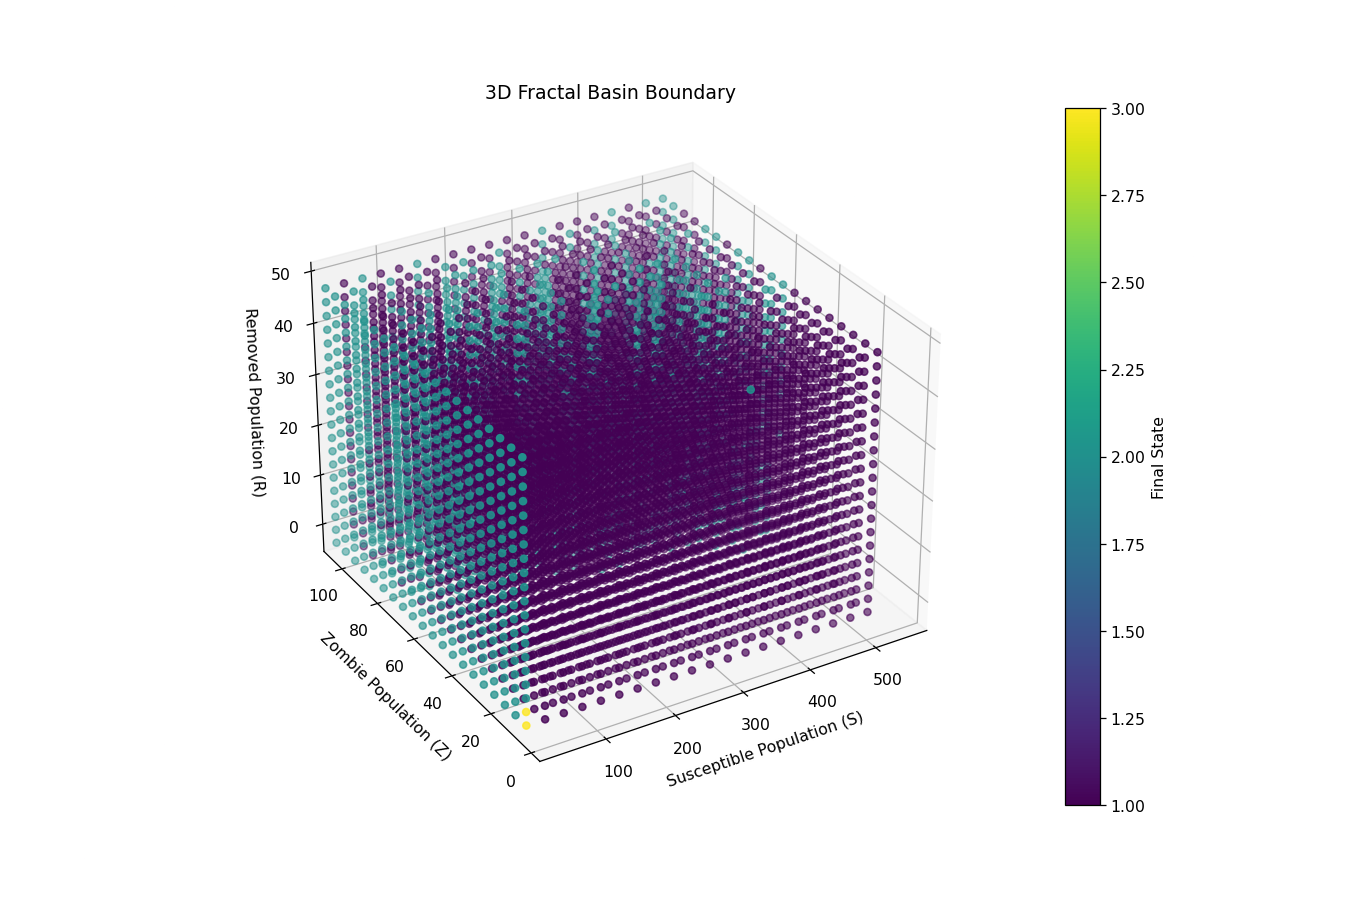

In [105]:
%matplotlib notebook

# Plot the 3D fractal basin boundary
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(S_vals, Z_vals, R_vals, c=states, cmap='viridis', marker='o')

# Label axes and color bar
ax.set_title('3D Fractal Basin Boundary')
ax.set_xlabel('Susceptible Population (S)')
ax.set_ylabel('Zombie Population (Z)')
ax.set_zlabel('Removed Population (R)')
color_bar = plt.colorbar(scatter, ax=ax, pad=0.1, label='Final State')

plt.ion()
plt.show()

## How does each variable impact the system?
To answer this we going to plot phase portrait and time-series for gamma, beta, and tau. These are the most importait variables impacting the survival of humans.

### Varying Gamma Values

In [71]:
#Define the variables
alpha = 0.05  # Zombie killing rate
beta = 0.055   # Infection rate
zeta = 0.005  # Resurrection rate
gamma = 0.3   # Cure rate
tau = 3          # Example value for Tau

#Let's assume that the system plays out in a short-timespan (simplify the model)
delta = 0        # Susceptible death rate
Pi = 0           # Susceptible birthrate

# Initial conditions
S0 = 500  # Initial susceptible population
Z0 = 1    # Initial zombie population
R0 = 0    # Initial removed population
initial_conditions = [S0, Z0, R0]  # Combine into an initial state vector

In [86]:
# Define the Heaviside function globally
def custom_heaviside(t, tau):
    return 1.0 if t >= tau else 0.0

# Define the ODE system globally
def cure_model_heaviside_varying(t, y, beta=0.055, gamma=0.3):
    S, Z, R = y
    H_t_tau = custom_heaviside(t, tau)  # Use the custom Heaviside function
    dS_dt = Pi + gamma * S * H_t_tau * Z - beta * S * Z - delta
    dZ_dt = beta * S * Z + zeta * R - alpha * S * Z - gamma * S * Z * H_t_tau
    dR_dt = delta + alpha * S * Z - zeta * R
    return [dS_dt, dZ_dt, dR_dt]

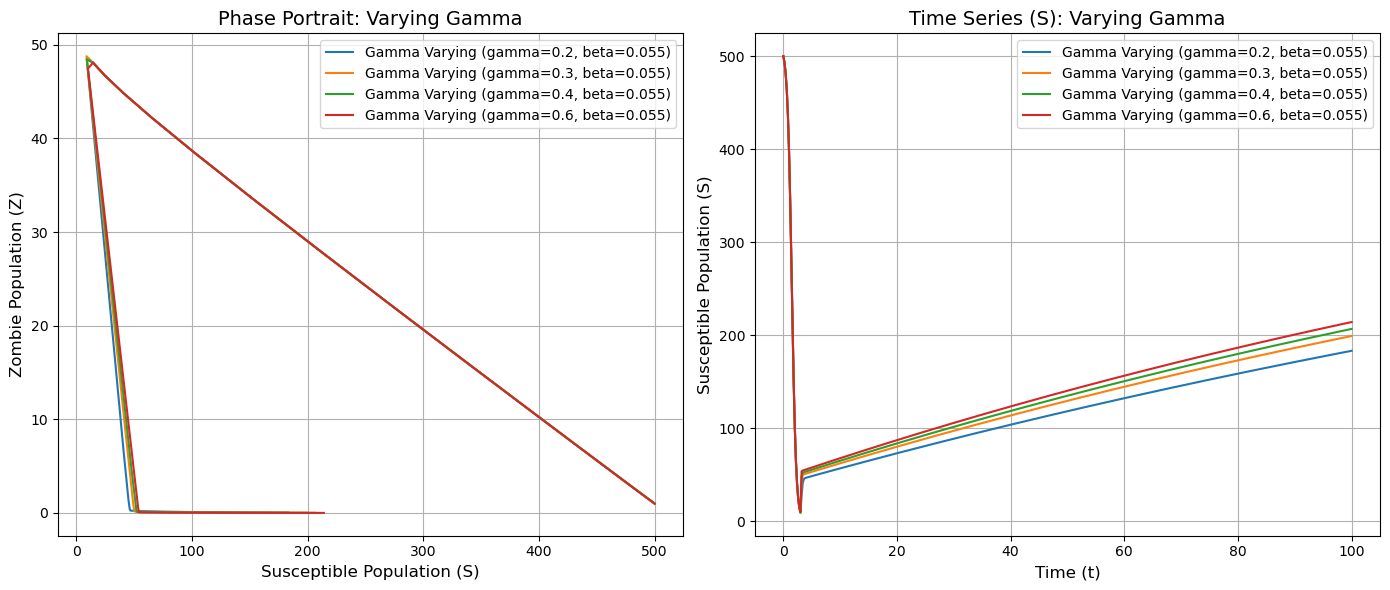

In [87]:
#Range of gamma values we want to investigate
gamma_values = [0.2, 0.3,0.4, 0.6]

# Function to solve and plot for a given gamma and beta
def solve_and_plot(gamma, beta, ax_phase, ax_time, label_suffix):
    def cure_model_heaviside_varying(t, y):
        S, Z, R = y
        H_t_tau = heaviside(t, tau)
        dS_dt = Pi + gamma * S * H_t_tau * Z - beta * S * Z - delta
        dZ_dt = beta * S * Z + zeta * R - alpha * S * Z - gamma * S * Z * H_t_tau
        dR_dt = delta + alpha * S * Z - zeta * R
        return [dS_dt, dZ_dt, dR_dt]
    
    # Use `solve_ivp` with the dynamically defined function
    solution = solve_ivp(cure_model_heaviside_varying, t_span, initial_conditions, t_eval=t_eval, method='RK45')
    S, Z, R = solution.y

    # Plot phase diagram
    ax_phase.plot(S, Z, label=f'{label_suffix} (gamma={gamma}, beta={beta})')
    # Plot time series for S
    ax_time.plot(solution.t, S, label=f'{label_suffix} (gamma={gamma}, beta={beta})')

# First set of plots: Varying gamma
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6))
axes1[0].set_title('Phase Portrait: Varying Gamma', fontsize=14)
axes1[0].set_xlabel('Susceptible Population (S)', fontsize=12)
axes1[0].set_ylabel('Zombie Population (Z)', fontsize=12)
axes1[0].grid(True)

axes1[1].set_title('Time Series (S): Varying Gamma', fontsize=14)
axes1[1].set_xlabel('Time (t)', fontsize=12)
axes1[1].set_ylabel('Susceptible Population (S)', fontsize=12)
axes1[1].grid(True)

# Loop through gamma values and solve the system
for gamma_value in gamma_values:
    solve_and_plot(gamma_value, beta, axes1[0], axes1[1], "Gamma Varying")

axes1[0].legend()
axes1[1].legend()
plt.tight_layout()
plt.show()

### Interactive Plot for Varying Gamma

In [94]:
# Interactive plotting function for varying gamma
def interactive_plot_gamma(gamma):
    solution = solve_ivp(
        lambda t, y: cure_model_heaviside_varying(t, y, beta, gamma),
        t_span,
        initial_conditions,
        t_eval=t_eval,
        method='RK45'
    )
    S, Z, R = solution.y

    # Plot results
    fig, (ax_phase, ax_time) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Phase Portrait
    ax_phase.plot(S, Z, label=f'gamma={gamma:.3f}', color='blue')
    ax_phase.set_title('Phase Portrait', fontsize=14)
    ax_phase.set_xlabel('Susceptible Population (S)', fontsize=12)
    ax_phase.set_ylabel('Zombie Population (Z)', fontsize=12)
    ax_phase.grid(True)
    ax_phase.legend()
    
    # Time Series
    ax_time.plot(solution.t, S, label=f'S (gamma={gamma:.3f})', color='green')
    ax_time.plot(solution.t, Z, label=f'Z (gamma={gamma:.3f})', color='red')
    ax_time.set_title('Time Series', fontsize=14)
    ax_time.set_xlabel('Time (t)', fontsize=12)
    ax_time.set_ylabel('Population', fontsize=12)
    ax_time.grid(True)
    ax_time.legend()
    
    plt.tight_layout()
    plt.show()

# Create an interactive slider for gamma
interact(interactive_plot_gamma, gamma=FloatSlider(value=0.3, min=0, max=1, step=0.05, description='Gamma'));



interactive(children=(FloatSlider(value=0.3, description='Gamma', max=1.0, step=0.05), Output()), _dom_classes…

As expected, gamma doesn't really impact the survival of human as the system is extremely sensitive to starting conditions that most scenarios would result in humans losing before the cure are delivered to the affected area.

### Varying Beta values

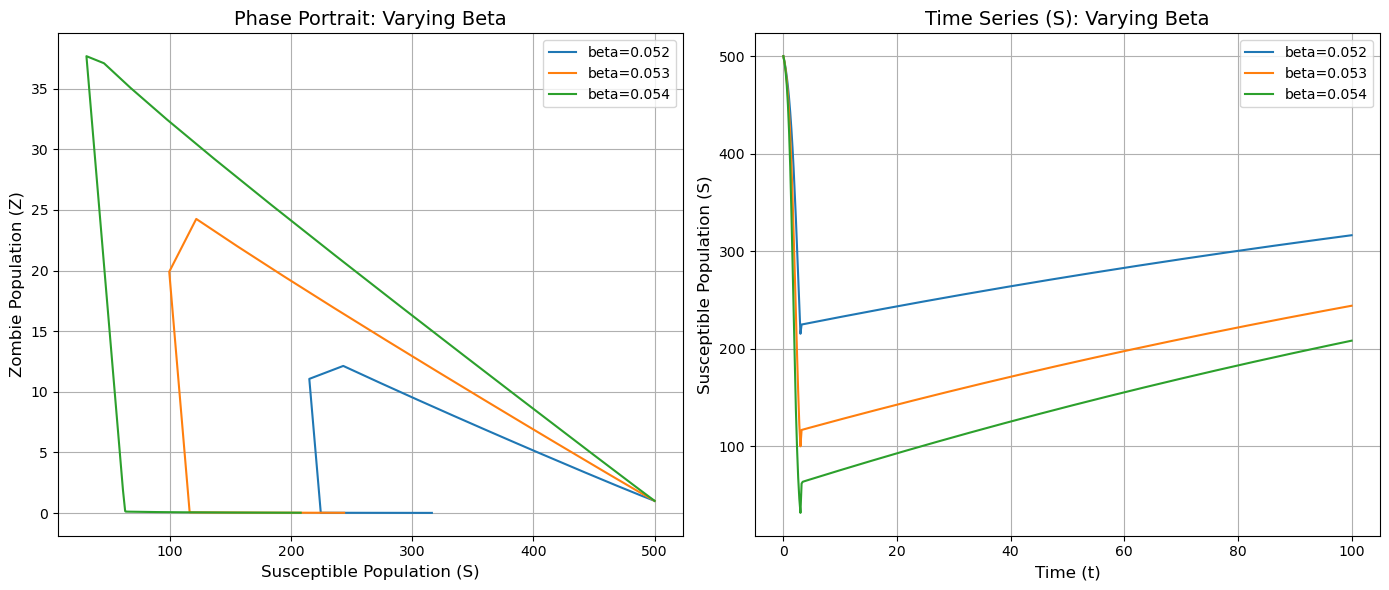

In [89]:
# Beta values to test
beta_values = [0.052, 0.053, 0.054]

def solve_and_plot_beta(beta, ax_phase, ax_time):
    def cure_model_heaviside_varying(t, y):
        S, Z, R = y
        H_t_tau = heaviside(t, tau)
        dS_dt = Pi + gamma * S * H_t_tau * Z - beta * S * Z - delta
        dZ_dt = beta * S * Z + zeta * R - alpha * S * Z - gamma * S * Z * H_t_tau
        dR_dt = delta + alpha * S * Z - zeta * R
        return [dS_dt, dZ_dt, dR_dt]
    
    # Solve the ODEs for the given beta
    solution = solve_ivp(cure_model_heaviside_varying, t_span, initial_conditions, t_eval=t_eval, method='RK45')
    S, Z, R = solution.y

    # Plot phase portrait (S vs Z)
    ax_phase.plot(S, Z, label=f'beta={beta}')
    # Plot time series for S
    ax_time.plot(solution.t, S, label=f'beta={beta}')

# Create plots to visualize the impact of varying beta
fig3, axes3 = plt.subplots(1, 2, figsize=(14, 6))

# Configure phase portrait subplot
axes3[0].set_title('Phase Portrait: Varying Beta', fontsize=14)
axes3[0].set_xlabel('Susceptible Population (S)', fontsize=12)
axes3[0].set_ylabel('Zombie Population (Z)', fontsize=12)
axes3[0].grid(True)

# Configure time series subplot
axes3[1].set_title('Time Series (S): Varying Beta', fontsize=14)
axes3[1].set_xlabel('Time (t)', fontsize=12)
axes3[1].set_ylabel('Susceptible Population (S)', fontsize=12)
axes3[1].grid(True)

# Loop through beta values and plot the results
for beta in beta_values:
    solve_and_plot_beta(beta, axes3[0], axes3[1])

# Add legends and display the plots
axes3[0].legend()
axes3[1].legend()
plt.tight_layout()
plt.show()

### Interactive Varying Beta Plot

In [93]:
# Interactive plotting function for varying beta
def interactive_plot_beta(beta):
    solution = solve_ivp(
        lambda t, y: cure_model_heaviside_varying(t, y, beta, gamma),
        t_span,
        initial_conditions,
        t_eval=t_eval,
        method='RK45'
    )
    S, Z, R = solution.y

    # Plot results
    fig, (ax_phase, ax_time) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Phase Portrait
    ax_phase.plot(S, Z, label=f'beta={beta:.3f}', color='blue')
    ax_phase.set_title('Phase Portrait', fontsize=14)
    ax_phase.set_xlabel('Susceptible Population (S)', fontsize=12)
    ax_phase.set_ylabel('Zombie Population (Z)', fontsize=12)
    ax_phase.grid(True)
    ax_phase.legend()
    
    # Time Series
    ax_time.plot(solution.t, S, label=f'S (beta={beta:.3f})', color='green')
    ax_time.plot(solution.t, Z, label=f'Z (beta={beta:.3f})', color='red')
    ax_time.set_title('Time Series', fontsize=14)
    ax_time.set_xlabel('Time (t)', fontsize=12)
    ax_time.set_ylabel('Population', fontsize=12)
    ax_time.grid(True)
    ax_time.legend()
    
    plt.tight_layout()
    plt.show()

# Create an interactive slider for beta
interact(interactive_plot_beta, beta=FloatSlider(value=0.055, min=0.050, max=0.07, step=0.001, description='Beta'));

interactive(children=(FloatSlider(value=0.055, description='Beta', max=0.07, min=0.05, step=0.001), Output()),…

We can see that the impact of beta is much more pronounced than gamma. This is because the system is very sensitive to the initial conditions, meaning that many times the system would reach the equilibrium before tau activates the cure term. This is why the Doomsday scenario is asymptomically stable.

### Varying Tau

In [37]:
#Define the variables
tau_values = [3, 5]  # Different cure delivery times to explore
gamma = 0.3 # Change the gamma back

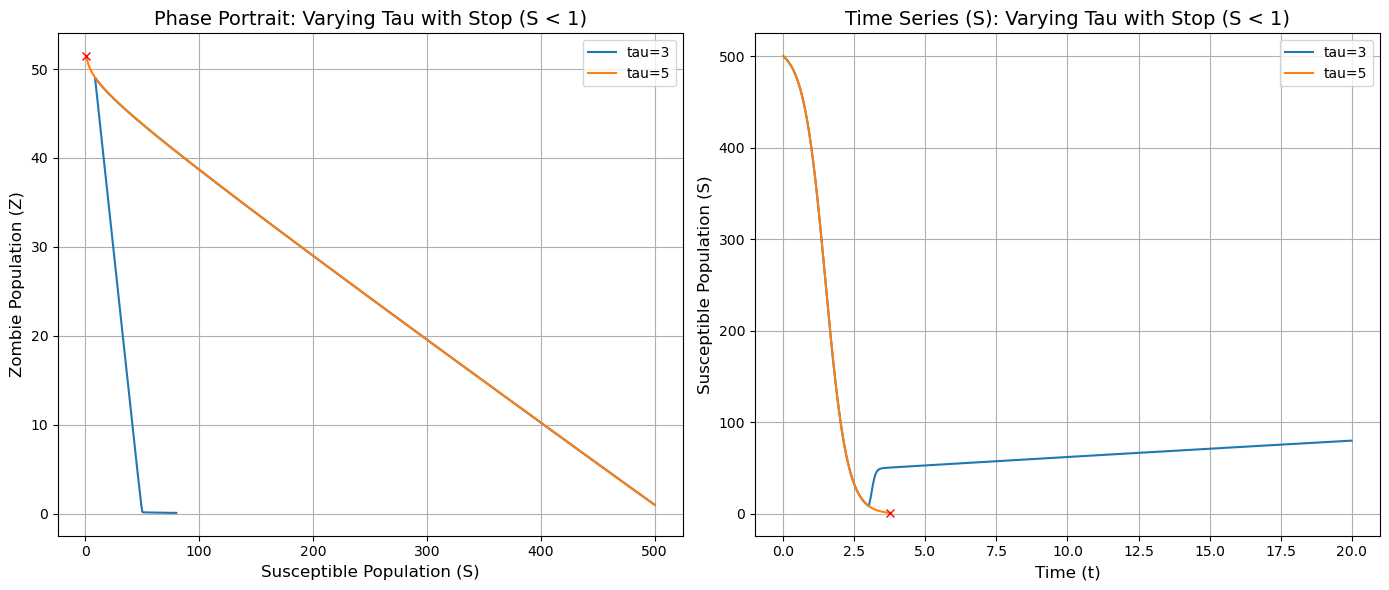

In [38]:
# Function to solve and plot for a given tau, stopping when S < 1
def solve_and_plot_tau_with_stop(tau, ax_phase, ax_time):
    def cure_model_heaviside_varying(t, y):
        S, Z, R = y
        H_t_tau = heaviside(t, tau)  # Use varying tau
        dS_dt = Pi + gamma * S * H_t_tau * Z - beta * S * Z - delta
        dZ_dt = beta * S * Z + zeta * R - alpha * S * Z - gamma * S * Z * H_t_tau
        dR_dt = delta + alpha * S * Z - zeta * R
        return [dS_dt, dZ_dt, dR_dt]

    # Event to stop the solver when S < 1
    def event_S_below_one(t, y):
        S, Z, R = y
        return S - 1

    event_S_below_one.terminal = True
    event_S_below_one.direction = -1

    # Solve the ODEs for the given tau with the event
    solution = solve_ivp(
        cure_model_heaviside_varying,
        t_span,
        initial_conditions,
        t_eval=t_eval,
        method='RK45',
        events=event_S_below_one,
    )
    S, Z, R = solution.y
    t = solution.t

    # Plot phase portrait (S vs Z)
    ax_phase.plot(S, Z, label=f'tau={tau}')
    if len(t) < len(t_eval):  # Check if the solver stopped early
        ax_phase.plot(S[-1], Z[-1], 'rx')  # Mark the stopping point with a cross

    # Plot time series for S
    ax_time.plot(t, S, label=f'tau={tau}')
    if len(t) < len(t_eval):  # Check if the solver stopped early
        ax_time.plot(t[-1], S[-1], 'rx')  # Mark the stopping point with a cross

# Create plots to visualize the impact of varying tau with stopping condition
fig4, axes4 = plt.subplots(1, 2, figsize=(14, 6))

# Configure phase portrait subplot
axes4[0].set_title('Phase Portrait: Varying Tau with Stop (S < 1)', fontsize=14)
axes4[0].set_xlabel('Susceptible Population (S)', fontsize=12)
axes4[0].set_ylabel('Zombie Population (Z)', fontsize=12)
axes4[0].grid(True)

# Configure time series subplot
axes4[1].set_title('Time Series (S): Varying Tau with Stop (S < 1)', fontsize=14)
axes4[1].set_xlabel('Time (t)', fontsize=12)
axes4[1].set_ylabel('Susceptible Population (S)', fontsize=12)
axes4[1].grid(True)

# Loop through tau values and plot the results
for tau in tau_values:
    solve_and_plot_tau_with_stop(tau, axes4[0], axes4[1])

# Add legends and display the plots
axes4[0].legend()
axes4[1].legend()
plt.tight_layout()
plt.show()


This show that tau is very influential in determining the outcome of the system. This is because the system is very sensitive to the starting conditions. This mean that often time the system would reach equilibrium before the cure term activates. Therefore tau, which controls the cure activation delay time, is very influential in determining the outcome of the system.

## Finding the Critical Value of each Variables
Now we will try to find the critical value of each variable. The problem with the current model is that Heaviside Functionn is non-continuous, making it difficult for the numerical solver to converge. This is shown below:

In [40]:
bifurcation_parameters = {
    "alpha": 0.05,  # Zombie killing rate
    "beta": 0.055,  # Infection rate
    "gamma": 0.3,   # Cure rate
    "zeta": 0.005,  # Resurrection rate
    "delta": 0.0,   # Susceptible death rate
    "Pi": 0.0,      # Susceptible birthrate
    "tau": None     # Cure delay will be varied dynamically
}

# Time span and evaluation points
t_span = (0, 200)  # Longer time to observe steady-state behavior
t_eval = np.linspace(t_span[0], t_span[1], 2000)

# Tau values to test
tau_values = np.linspace(3, 5, 20)  # Fine resolution between tau=3 and tau=5

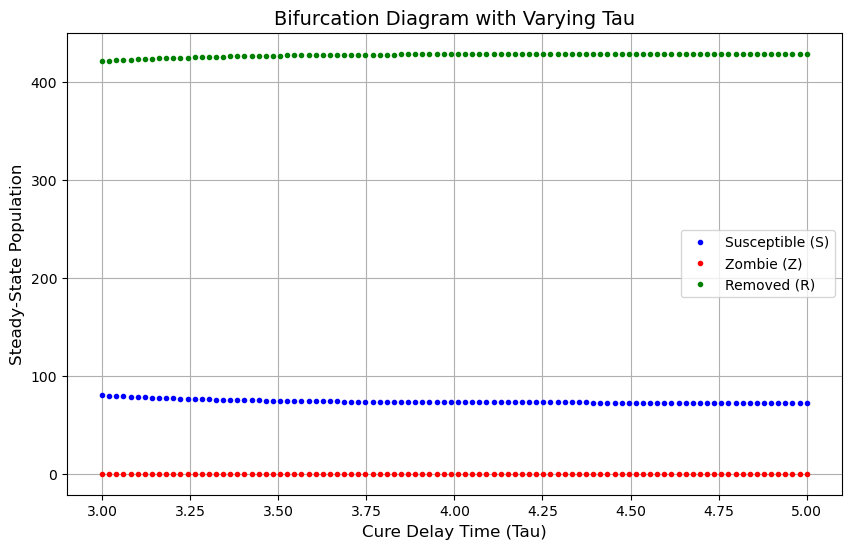

In [44]:
# Time span and evaluation points
t_span = (0, 20)  # Longer time to observe steady-state behavior
t_eval = np.linspace(t_span[0], t_span[1], 2000)

# Tau values to test
tau_values = np.linspace(3, 5, 100)  # Fine resolution between tau=3 and tau=5

# Store steady-state results
steady_states = []

# Compute steady states for each tau
for tau in tau_values:
    # Update tau dynamically in the new parameter dictionary
    bifurcation_parameters["tau"] = tau

    # Solve the system using solve_ivp
    solution = solve_ivp(
        cure_model_heaviside,
        t_span=t_span,
        y0=initial_conditions,
        t_eval=t_eval,
        method='RK45',
        args=(bifurcation_parameters,)
    )
    
    # Extract steady-state values (last time points)
    S, Z, R = solution.y
    steady_states.append([S[-1], Z[-1], R[-1]])

# Convert to NumPy array for easier slicing
steady_states = np.array(steady_states)
S_steady, Z_steady, R_steady = steady_states[:, 0], steady_states[:, 1], steady_states[:, 2]

# Plot bifurcation diagram
plt.figure(figsize=(10, 6))

# Plot steady-state values of S, Z, and R against tau
plt.plot(tau_values, S_steady, 'b.', label='Susceptible (S)')
plt.plot(tau_values, Z_steady, 'r.', label='Zombie (Z)')
plt.plot(tau_values, R_steady, 'g.', label='Removed (R)')

plt.xlabel('Cure Delay Time (Tau)', fontsize=12)
plt.ylabel('Steady-State Population', fontsize=12)
plt.title('Bifurcation Diagram with Varying Tau', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

This doesn't look right, so we will approximate the heaviside function.

### Logistic Function

In [45]:
# Parameters (default values)
default_params = {
    "gamma": 0.3,   # Cure effectiveness
    "beta": 0.053,  # Infection rate
    "zeta": 0.005,  # Resurrection rate
    "alpha": 0.05,  # Zombie killing rate
    "delta": 0.0,   # Susceptible death rate
    "Pi": 0.0,      # Susceptible birthrate
    "tau": 3      # Cure delay
}

In [48]:
# Fixed-point equations - Steady state, therefore tau=tau
def fixed_points(vary_param, vars, param_name, params):
    S, Z, R = vars
    params[param_name] = vary_param  # Update the parameter being varied
    gamma, beta, zeta, alpha, delta, Pi, tau = (
        params["gamma"], params["beta"], params["zeta"], params["alpha"], 
        params["delta"], params["Pi"], params["tau"]
    )
    exp_term = 1 / (1 + np.exp(-100 * (tau - tau)))  # Steeper logistic function
    dS = Pi + gamma * S * Z * exp_term - beta * S * Z - delta
    dZ = beta * S * Z + zeta * R - alpha * S * Z - gamma * S * Z * exp_term
    dR = delta + alpha * S * Z - zeta * R
    return [dS, dZ, dR]

# Jacobian matrix
def jacobian(S, Z, R, params):
    gamma, beta, zeta, alpha, delta, Pi, tau = (
        params["gamma"], params["beta"], params["zeta"], params["alpha"], 
        params["delta"], params["Pi"], params["tau"]
    )
    exp_term = 1 / (1 + np.exp(-10 * (tau - tau)))  # Steeper logistic function
    J = np.array([
        [-beta * Z - delta, gamma * S * exp_term - beta * S, 0],
        [beta * Z - alpha * Z - gamma * exp_term, beta * S - alpha * S - gamma * S * exp_term, zeta],
        [alpha * Z, alpha * S, -zeta]
    ])
    return J

# Bifurcation analysis function
def bifurcation_analysis(param_name, param_range, params):
    fixed_points_data = []
    stability_data = []

    initial_guess = [0.1, 0.1, 0.1]  # Initial guess for fixed points

    for vary_param in param_range:
        try:
            solution = fsolve(lambda vars: fixed_points(vary_param, vars, param_name, params), initial_guess)
        except RuntimeError:
            solution = [np.nan, np.nan, np.nan]

        fixed_points_data.append(solution)
        initial_guess = solution  # Update the initial guess

        # Compute Jacobian and stability
        if not np.isnan(solution).any():
            S_star, Z_star, R_star = solution
            J = jacobian(S_star, Z_star, R_star, params)
            eigenvalues = eigvals(J)
            stability_data.append(np.max(np.real(eigenvalues)))
        else:
            stability_data.append(np.nan)

    # Convert results to arrays
    fixed_points_data = np.array(fixed_points_data)
    stability_data = np.array(stability_data)

    # Smooth data for visualization
    fixed_points_data = uniform_filter1d(fixed_points_data, size=5, axis=0)

    # Detect bifurcation points (where stability changes)
    bifurcation_indices = np.where(np.diff(np.sign(stability_data)) != 0)[0]
    bifurcation_points = param_range[bifurcation_indices]

    return fixed_points_data, stability_data, bifurcation_points

# Plotting function
def plot_bifurcation(param_name, param_range, fixed_points_data, stability_data, bifurcation_points):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Bifurcation diagram
    axes[0].plot(param_range, fixed_points_data[:, 0], label='S* (Susceptibles)')
    axes[0].plot(param_range, fixed_points_data[:, 1], label='Z* (Zombies)')
    axes[0].plot(param_range, fixed_points_data[:, 2], label='R* (Removed)')
    axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[0].set_xlabel(f'{param_name.capitalize()}')
    axes[0].set_ylabel('Fixed Points')
    axes[0].set_title('Bifurcation Diagram')
    axes[0].legend()
    axes[0].grid()

    # Stability plot
    axes[1].plot(param_range, stability_data, label='Max Real Eigenvalue')
    axes[1].axhline(0, color='red', linestyle='--', label='Stability Threshold')
    axes[1].set_xlabel(f'{param_name.capitalize()}')
    axes[1].set_ylabel('Max Real Eigenvalue')
    axes[1].set_title('Stability Analysis')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()
    
    # Print bifurcation points
    print(f"Bifurcation Points Detected for {param_name.capitalize()}:")
    for point in bifurcation_points:
        print(f"{param_name.capitalize()}: {point:.4f}")

C:\Users\beam_\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


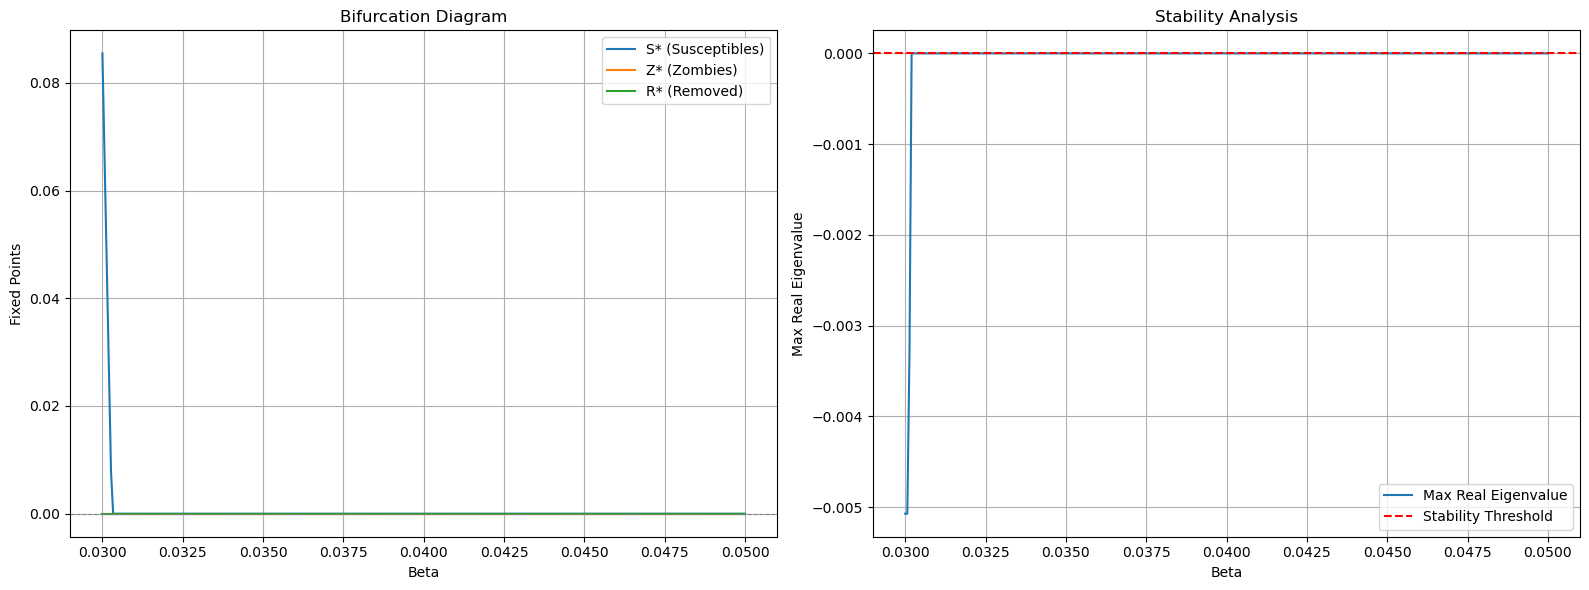

Bifurcation Points Detected for Beta:
Beta: 0.0311
Beta: 0.0311
Beta: 0.0313


In [49]:
# Run bifurcation analysis for beta
param_name = "beta"
param_range = np.linspace(0.03, 0.05, 300)
fixed_points_data, stability_data, bifurcation_points = bifurcation_analysis(param_name, param_range, default_params)
plot_bifurcation(param_name, param_range, fixed_points_data, stability_data, bifurcation_points)

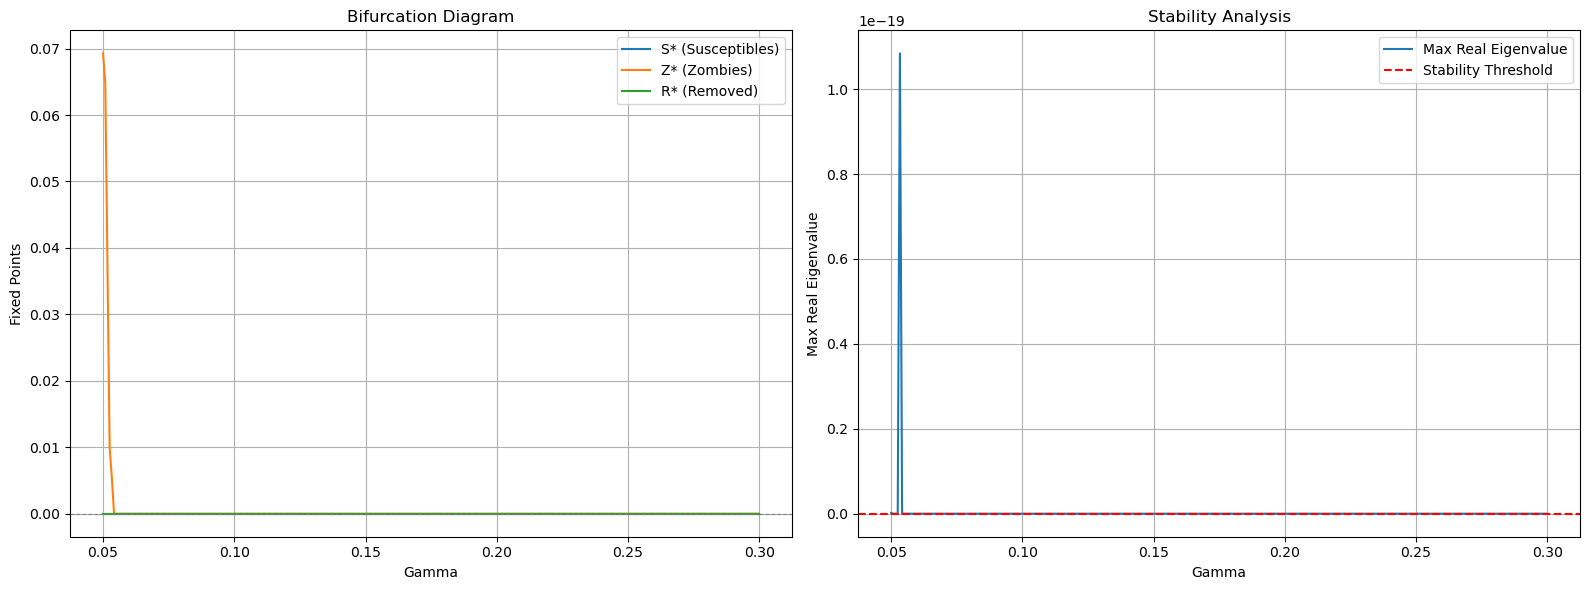

Bifurcation Points Detected for Gamma:
Gamma: 0.0500
Gamma: 0.0517
Gamma: 0.0542
Gamma: 0.0550
Gamma: 0.0559
Gamma: 0.0592
Gamma: 0.0993


In [50]:
# Run bifurcation analysis for gamma
param_name = "gamma"
param_range = np.linspace(0.05, 0.3, 300)
fixed_points_data, stability_data, bifurcation_points = bifurcation_analysis(param_name, param_range, default_params)
plot_bifurcation(param_name, param_range, fixed_points_data, stability_data, bifurcation_points)

### What about Tau?
So because the previous 2 numerical solver assume time is at tau. Obviously this method wouldn't work because tau introduces a time-dependent dynamic, so we can't use fixed-point analysis. Instead we run time-series simulations repeatedly with varying tau, to find which value of tau would cause the susceptible population to drop below 1. [__Interactive Plot in Wolfram Notebook__]

In [96]:
# Range of tau values for analysis
tau_values = np.linspace(5, 6, 300) # Use this to find more precise critical points
#tau_values = [4,5,6] #Use this for pretty plots

In [97]:
# Parameters for time-series analysis
params = {
    "gamma": 0.3,   # Cure effectiveness
    "beta": 0.053,  # Infection rate
    "zeta": 0.005,  # Resurrection rate
    "alpha": 0.05,  # Zombie killing rate
    "delta": 0.0,   # Susceptible death rate
    "Pi": 0.0,      # Susceptible birthrate
}

# Time span and initial conditions
t_span = (0, 50)  # Simulation time span
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Evaluation points
S0, Z0, R0 = 100, 10, 0  # Initial populations

In [98]:
# Cure model
def cure_model_approx(t, y, params, tau):
    S, Z, R = y
    gamma, beta, zeta, alpha, delta, Pi = (
        params["gamma"], params["beta"], params["zeta"], params["alpha"],
        params["delta"], params["Pi"]
    )
    H_t_tau = heaviside(t, tau)
    dS_dt = Pi + gamma * S * H_t_tau * Z - beta * S * Z - delta
    dZ_dt = beta * S * Z + zeta * R - alpha * S * Z - gamma * S * Z * H_t_tau
    dR_dt = delta + alpha * S * Z - zeta * R
    return [dS_dt, dZ_dt, dR_dt]

<IPython.core.display.Javascript object>


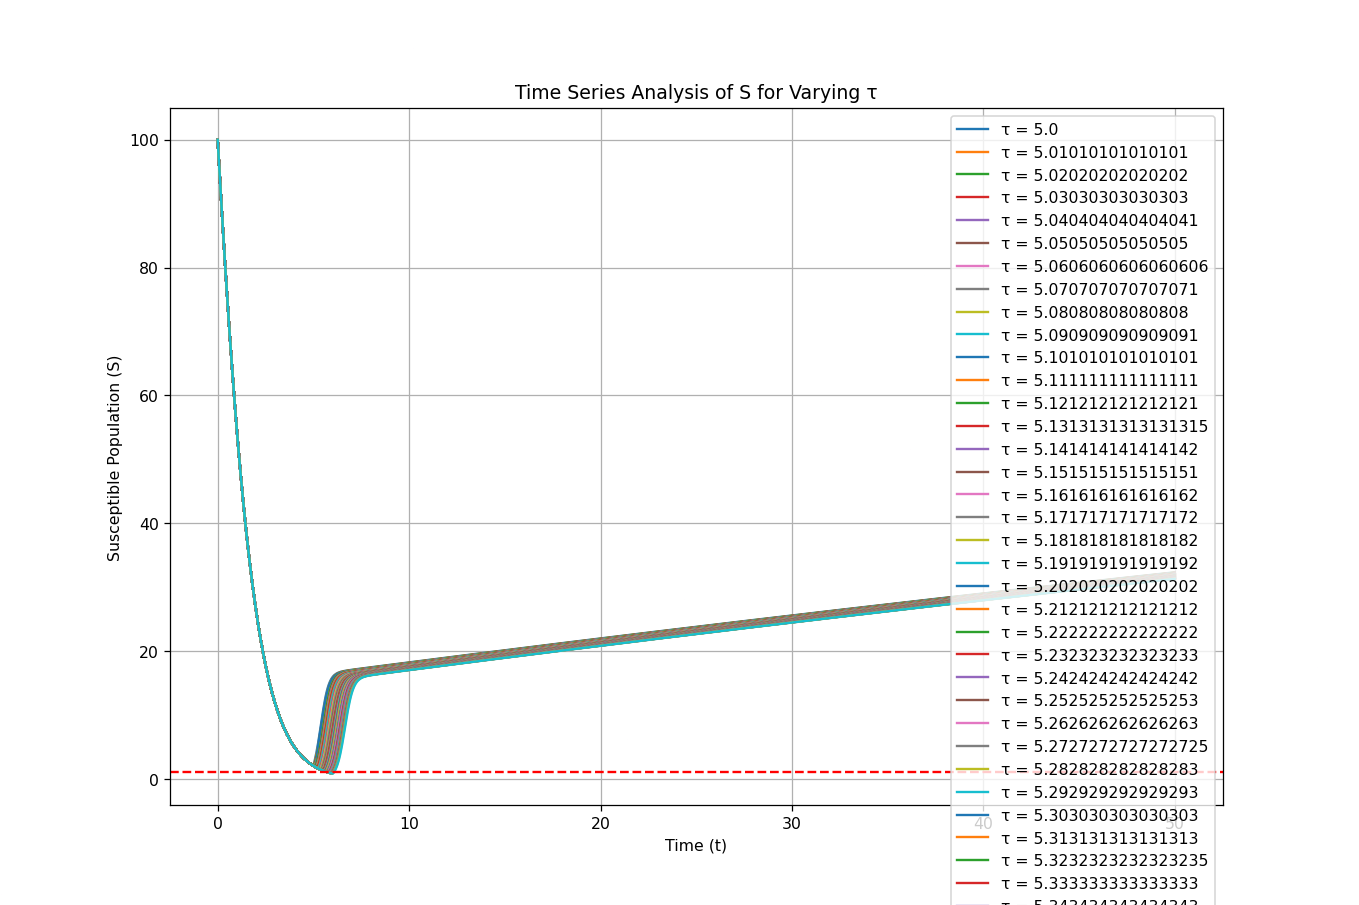

For τ = 5.0, S never falls below 1 in the simulation.
For τ = 5.01010101010101, S never falls below 1 in the simulation.
For τ = 5.02020202020202, S never falls below 1 in the simulation.
For τ = 5.03030303030303, S never falls below 1 in the simulation.
For τ = 5.040404040404041, S never falls below 1 in the simulation.
For τ = 5.05050505050505, S never falls below 1 in the simulation.
For τ = 5.0606060606060606, S never falls below 1 in the simulation.
For τ = 5.070707070707071, S never falls below 1 in the simulation.
For τ = 5.08080808080808, S never falls below 1 in the simulation.
For τ = 5.090909090909091, S never falls below 1 in the simulation.
For τ = 5.101010101010101, S never falls below 1 in the simulation.
For τ = 5.111111111111111, S never falls below 1 in the simulation.
For τ = 5.121212121212121, S never falls below 1 in the simulation.
For τ = 5.1313131313131315, S never falls below 1 in the simulation.
For τ = 5.141414141414142, S never falls below 1 in the simulatio

In [106]:
# Analyze time series for each tau
plt.figure(figsize=(12, 8))

for tau in tau_values:
    # Solve the system
    solution = solve_ivp(cure_model_approx, t_span, [S0, Z0, R0], t_eval=t_eval, args=(params, tau))
    S, Z, R = solution.y

    # Determine when S becomes less than 1
    time_S_below_1 = t_eval[np.where(S < 1)[0]]
    if len(time_S_below_1) > 0:
        print(f"For τ = {tau}, S falls below 1 at t = {time_S_below_1[0]:.2f}")
    else:
        print(f"For τ = {tau}, S never falls below 1 in the simulation.")

    # Plot S over time
    plt.plot(t_eval, S, label=f"τ = {tau}")

plt.axhline(1, color='red', linestyle='--', label="S = 1 Threshold")
plt.xlabel("Time (t)")
plt.ylabel("Susceptible Population (S)")
plt.title("Time Series Analysis of S for Varying τ")
plt.legend()
plt.grid()
plt.show()

For interactive animation of this plot, refer to Wolfram Mathematica Notebook

## So, what's the implication of using Logistic Function?
So, logistic function is continuous and when we use it to approximate Heaviside function we assume that the variable representing the steepness of the transition (k), is high. So how does the steepness impact the system?

In [109]:
# Logistic function for smooth Heaviside approximation
def logistic(t, tau, k):
    return 1 / (1 + np.exp(-k * (t - tau)))

# Cure model with logistic Heaviside
def cure_model_logistic(t, y, k):
    S, Z, R = y
    exp_term = logistic(t, tau, k)
    dS_dt = Pi + gamma * S * Z * exp_term - beta * S * Z - delta
    dZ_dt = beta * S * Z + zeta * R - alpha * S * Z - gamma * S * Z * exp_term
    dR_dt = delta + alpha * S * Z - zeta * R
    return [dS_dt, dZ_dt, dR_dt]

<IPython.core.display.Javascript object>


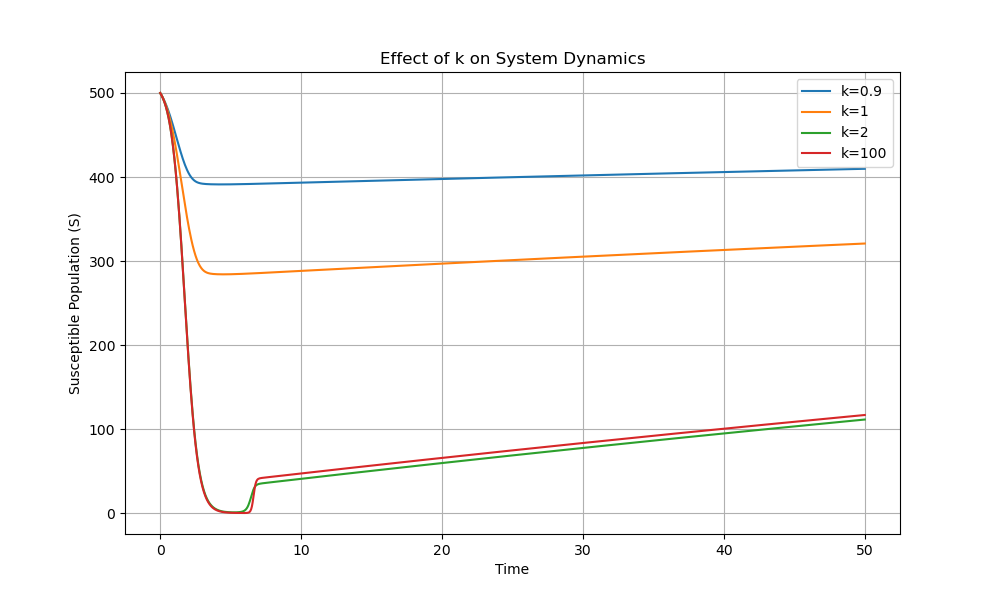

In [127]:
# Parameters
k_values = [0.9,1,2, 100]  # Steepness of logistic function
results = []

# Time range and initial conditions
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 1000)
initial_conditions = [500, 1, 0]

# Solve for different k-values
for k in k_values:
    sol = solve_ivp(cure_model_logistic, t_span, initial_conditions, t_eval=t_eval, args=(k,))
    results.append(sol)


# Plot time-series for each k
plt.figure(figsize=(10, 6))
for i, k in enumerate(k_values):
    S, Z, R = results[i].y
    plt.plot(t_eval, S, label=f'k={k}')
plt.xlabel('Time')
plt.ylabel('Susceptible Population (S)')
plt.title('Effect of k on System Dynamics')
plt.legend()
plt.grid(True)
plt.show()

There is minimal effect of k on the system, unless k is small (e.g. $k \leq 1$ in this specfic parameter), then it would impact the system. This is because the smoother curve meant the cure term is activated earlier, often saving humans from extinction. Knowing this, does this mean the system is more chaotic?

In [128]:
# Interpolation function for solver results
def interpolate_solution(t_eval, sol):
    interp_func = interp1d(sol.t, sol.y, kind='linear', axis=-1, fill_value="extrapolate")
    return interp_func(t_eval)

def compute_lyapunov(k):
    # Solve original and perturbed systems
    perturbed_conditions = [500 + epsilon, 1, 0]
    sol_original = solve_ivp(cure_model_logistic, t_span, initial_conditions, t_eval=t_eval, args=(k,))
    sol_perturbed = solve_ivp(cure_model_logistic, t_span, perturbed_conditions, t_eval=t_eval, args=(k,))

    # Interpolate solutions to match time points
    S_orig, Z_orig, R_orig = interpolate_solution(t_eval, sol_original)
    S_pert, Z_pert, R_pert = interpolate_solution(t_eval, sol_perturbed)

    # Compute separation and log separation
    separation = np.sqrt((S_orig - S_pert)**2 + (Z_orig - Z_pert)**2 + (R_orig - R_pert)**2)
    log_separation = np.log(separation[1:] / epsilon)
    time = t_eval[1:]
    return np.mean(log_separation / time)

In [129]:
# Calculate Lyapunov exponents for each k
lyapunov_exponents = [compute_lyapunov(k) for k in k_values]
for k, lyapunov in zip(k_values, lyapunov_exponents):
    print(f'k={k}, Largest Lyapunov Exponent: {lyapunov:.4f}')

k=0.9, Largest Lyapunov Exponent: -0.0237
k=1, Largest Lyapunov Exponent: -0.0177
k=2, Largest Lyapunov Exponent: -0.0100
k=100, Largest Lyapunov Exponent: -0.0092


Results show that it does not particularly impact the chaos. Regardless, the perturbation resulted from this is neglible as discussed in earlier section. This means that the logistic function is a good approximation of a heaviside function, given that k is high.

In the context of the storyline, the value of k could represent how long it takes for the cure to be effectively deployed in the area. For example, tau may represent the time it takes to transport the cure to the area and k could represent how fast the medical team could setup local clinics and local logistics to adminster the cure.